Load the JSONs

In [94]:
import os
import json

json_files_dir = os.path.join(os.getcwd(), 'json')
json_files = [f for f in os.listdir(json_files_dir) if f.endswith('.json')]

CONTINENTS AND COUNTRIES PROBES USED

In [ ]:
# South America
## Brazil, Uruguay and Chile

#Asia
## China, Mongolia and India

# North America
## USA, Canada, Mexico

In [3]:
%%capture
!pip install matplotlib
!pip install requests

FUNCTION TO GET PROBE COUNTRY BY IP

In [96]:
import requests
from collections import defaultdict
    
def get_probe_country(probe_id):
    url = f"https://atlas.ripe.net/api/v2/probes/{probe_id}/"
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    data = response.json()
    
    probe_country = data['country_code']
    return str(probe_country)
    


CLASSES FOR EASIER ACCESS TO ATTRIBUTES

In [100]:
class Probe:
    def __init__(self, name, values):
        self.name = name
        if isinstance(values, dict):
            # Modify the dictionary to change "from" to "from_ip"
            modified_values = {("from_ip" if k == "from" else k): v for k, v in values.items()}
            self.__dict__.update(modified_values)
            self.country = get_probe_country(self.prb_id)
        else:
            raise TypeError("Expected a dictionary")

class Destination:
    def __init__(self, name):
        self.name = name
        self.probes = []

    def add_probe(self, probe):
        if isinstance(probe, Probe):
            self.probes.append(probe)
        else:
            raise TypeError("Expected a Probe instance")

TO LOAD JSON INTO CLASSES

In [101]:
destinations = {}

for json_file in json_files:
    with open(os.path.join(json_files_dir, json_file), 'r') as f:
        data = json.load(f)
        name = json_file.split('.')[0]
        destination = Destination(name)
        destinations[name] = destination
        for measure in data:
            probe = Probe(name, measure)
            destination.add_probe(probe)
        
print(destinations['bet365'].probes[12].prb_id)

60822


TO SAVE IN PICKLE

In [102]:
import pickle

pickle_file_path = os.path.join(os.getcwd(), "destinations.pickle")
with open(pickle_file_path, "wb") as pickle_file:
    pickle.dump(destinations, pickle_file)

TO LOAD THE PICKLE

In [6]:
import pickle
import os

pickle_file_path = os.path.join(os.getcwd(), "destinations.pickle")
with open(pickle_file_path, "rb") as pickle_file:
    destinations = pickle.load(pickle_file)

PROBES IDS BY COUNTRY

In [110]:
# Define the countries by continent
continents = {
    "South America": ["BR", "UY", "CL"],
    "Asia": ["CN", "MN", "IN"],
    "North America": ["US", "CN", "MX"]
}

probes_by_continent_country = {
    continent: {country: set() for country in countries}
    for continent, countries in continents.items()
}

# Iterate over all destinations and their probes
for destination_name, destination in destinations.items():
    for probe in destination.probes:
        # Check which continent and country the probe's country belongs to
        for continent, countries in continents.items():
            if probe.country in countries:
                probes_by_continent_country[continent][probe.country].add(probe.prb_id)  # Use 'add' to avoid duplicates

# Print probe IDs for each continent and country
for continent, countries in probes_by_continent_country.items():
    print(f"{continent}:")
    for country, probe_ids in countries.items():
        print(f"  {country}: {list(probe_ids)}")

South America:
  BR: [12808, 28708, 65373, 1005287]
  UY: [17826, 1003171, 23526, 1004969, 7147, 21559]
  CL: [7308, 6554, 30139, 1007645, 1007198, 51486]
Asia:
  CN: [1008244, 63018, 1006180]
  MN: [61872, 6723, 62788]
  IN: [60592, 60289, 61030]
North America:
  US: [62226, 60822, 51350]
  CN: [1008244, 63018, 1006180]
  MX: [63001, 65083, 1003249, 25182]


FUNCTION TO DISPLAY SPECIFIC COUNTRY

In [104]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

def plot_rtt_for_country(destination_country_probes, country_code, min_rtt=2):
    """
    Plots the average RTT over time for a specified country across all destinations.
    
    Args:
    - destination_country_probes: A dictionary containing probe data by destination and country.
    - country_code: The country code (e.g., 'MN' for Mongolia) for which to plot the RTT data.
    - min_rtt: The minimum RTT (in ms) to consider for the plot. Default is 2ms.
    """
    # Iterate over all destinations and create a plot for the specified country
    for destination, countries in destination_country_probes.items():
        if country_code in countries:  # Only process if the specified country has probes
            timestamp_rtt = defaultdict(list)  # Initialize dictionary for the current destination

            # Collect RTT data for the specified country and destination
            for probe in countries[country_code]:
                if probe.result and probe.result[-1].get("result"):
                    rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                    timestamp = probe.timestamp
                    if rtt > min_rtt:  # Only consider RTTs greater than the specified minimum RTT
                        timestamp_rtt[timestamp].append(rtt)

            # Calculate the average RTT for each timestamp
            average_rtt = {timestamp: sum(rtts) / len(rtts) for timestamp, rtts in timestamp_rtt.items()}

            # Sort the timestamps for plotting
            sorted_timestamps = sorted(average_rtt.keys())
            sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
            sorted_rtts = [average_rtt[timestamp] for timestamp in sorted_timestamps]

            # Plot the data for the current destination
            plt.figure(figsize=(10, 5))
            plt.plot(sorted_times, sorted_rtts, linestyle='-', color='b', label='Average RTT')

            # Format the x-axis to display date and time correctly
            ax = plt.gca()  # Get current axis
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())

            # Labels and formatting
            plt.xlabel('Time')
            plt.ylabel('Average RTT (ms)')
            plt.title(f'Average RTT per Timestamp for {country_code} - Destination: {destination}')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


BRASIL

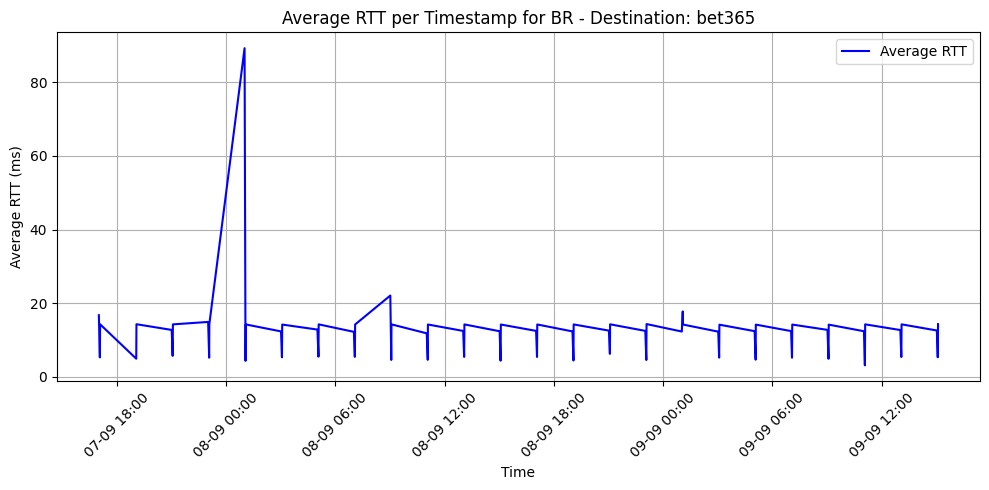

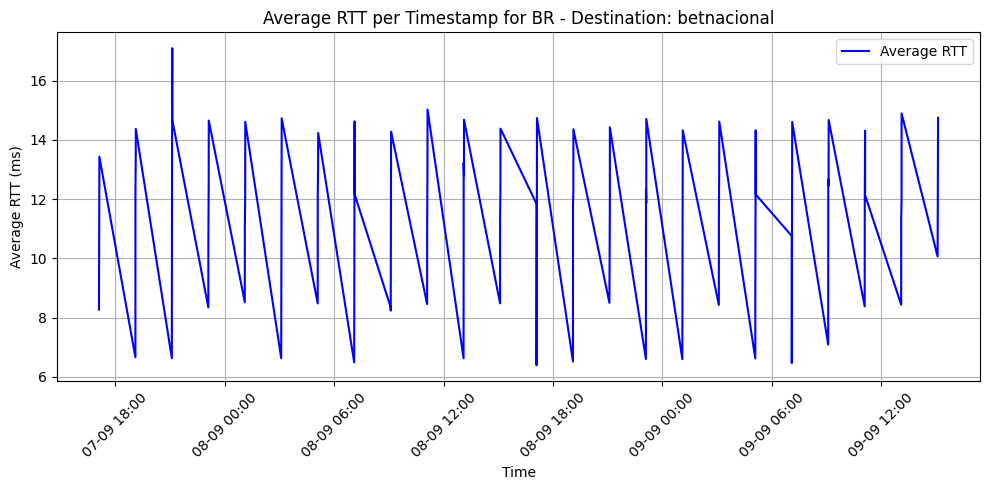

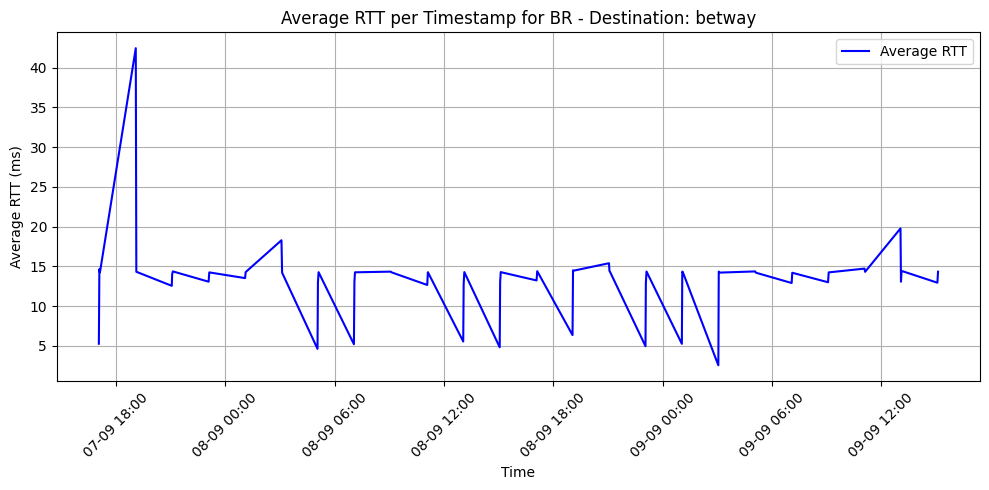

In [105]:
plot_rtt_for_country(destination_country_probes, 'BR', min_rtt=2)

CHINA

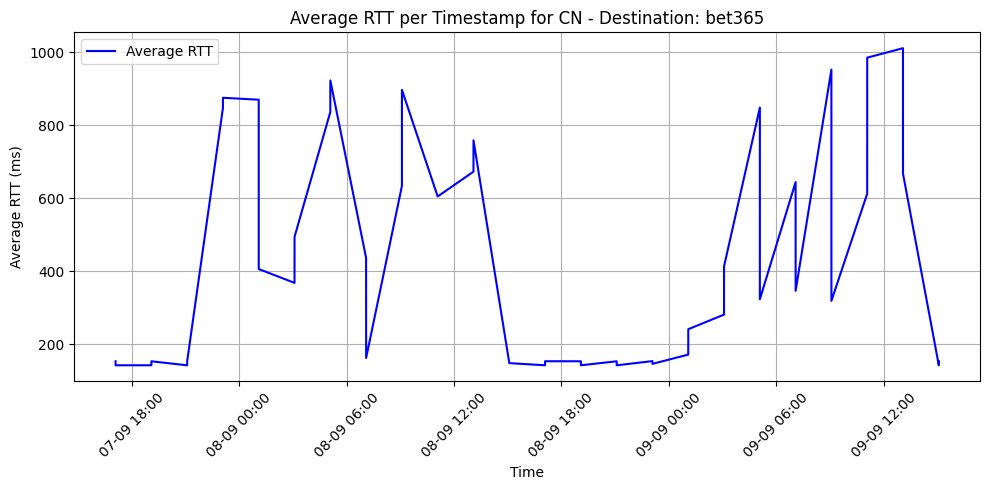

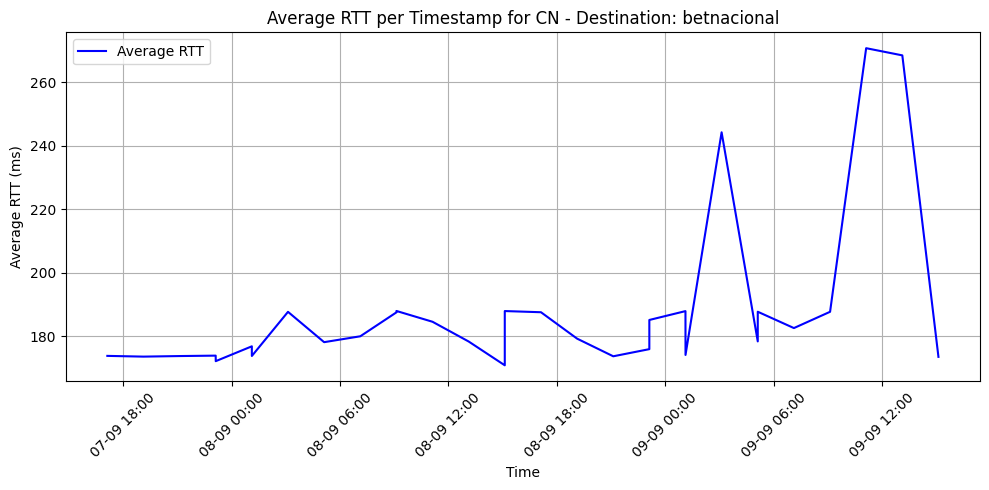

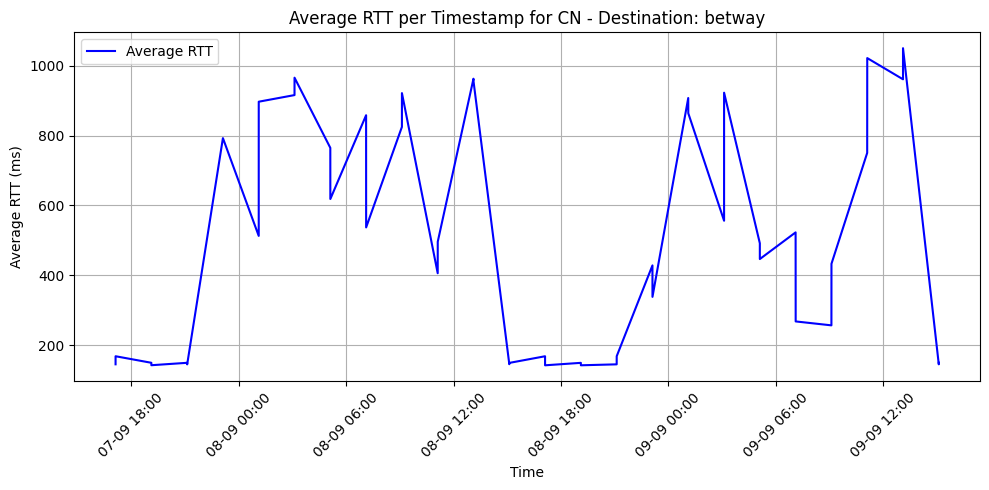

In [106]:
plot_rtt_for_country(destination_country_probes, 'CN', min_rtt=2)

MONGOLIA

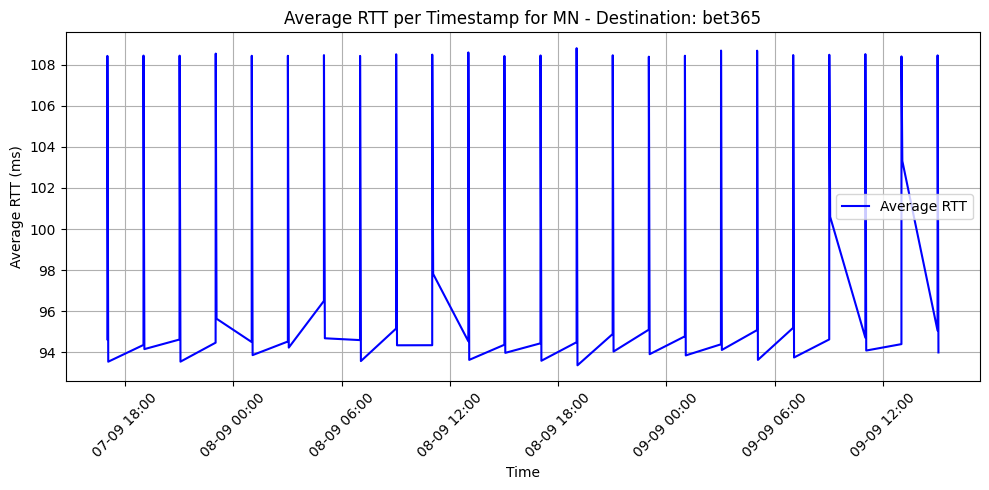

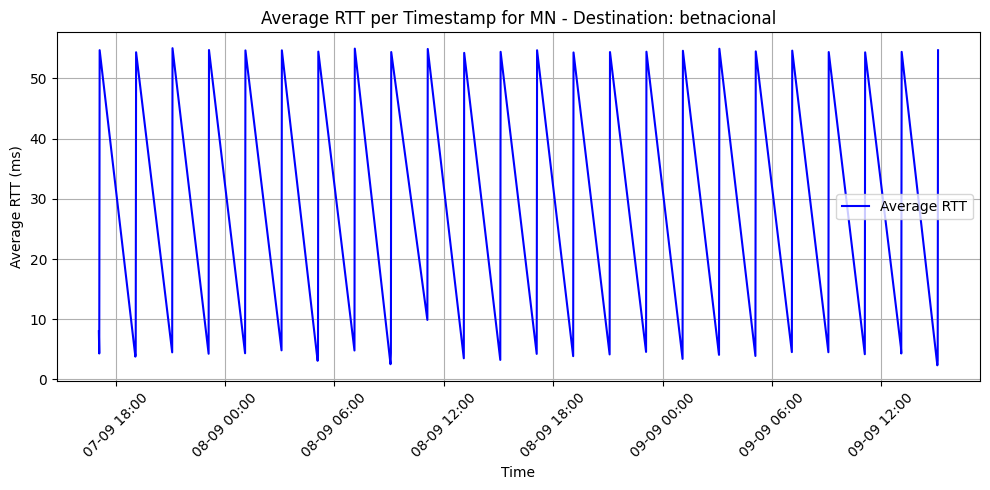

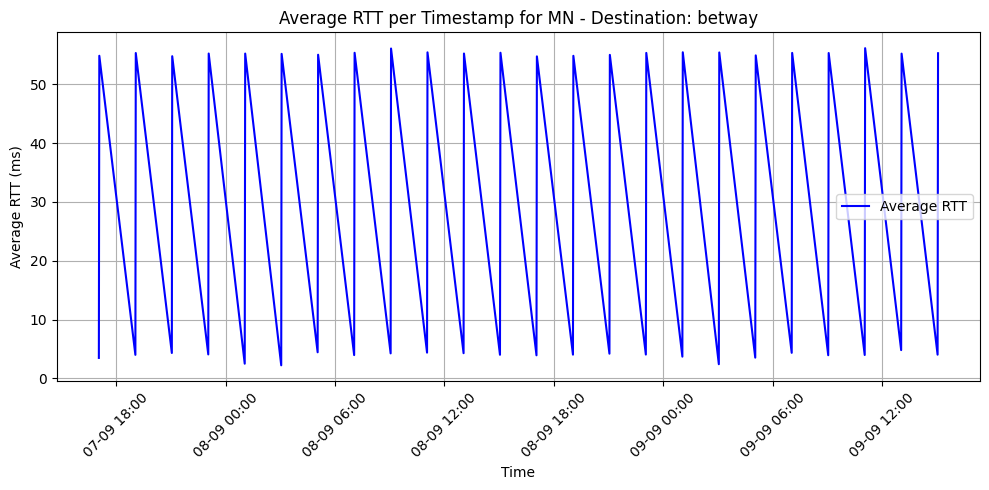

In [107]:
plot_rtt_for_country(destination_country_probes, 'MN', min_rtt=2)

FOR ALL COUNTRIES BY CONTINENT

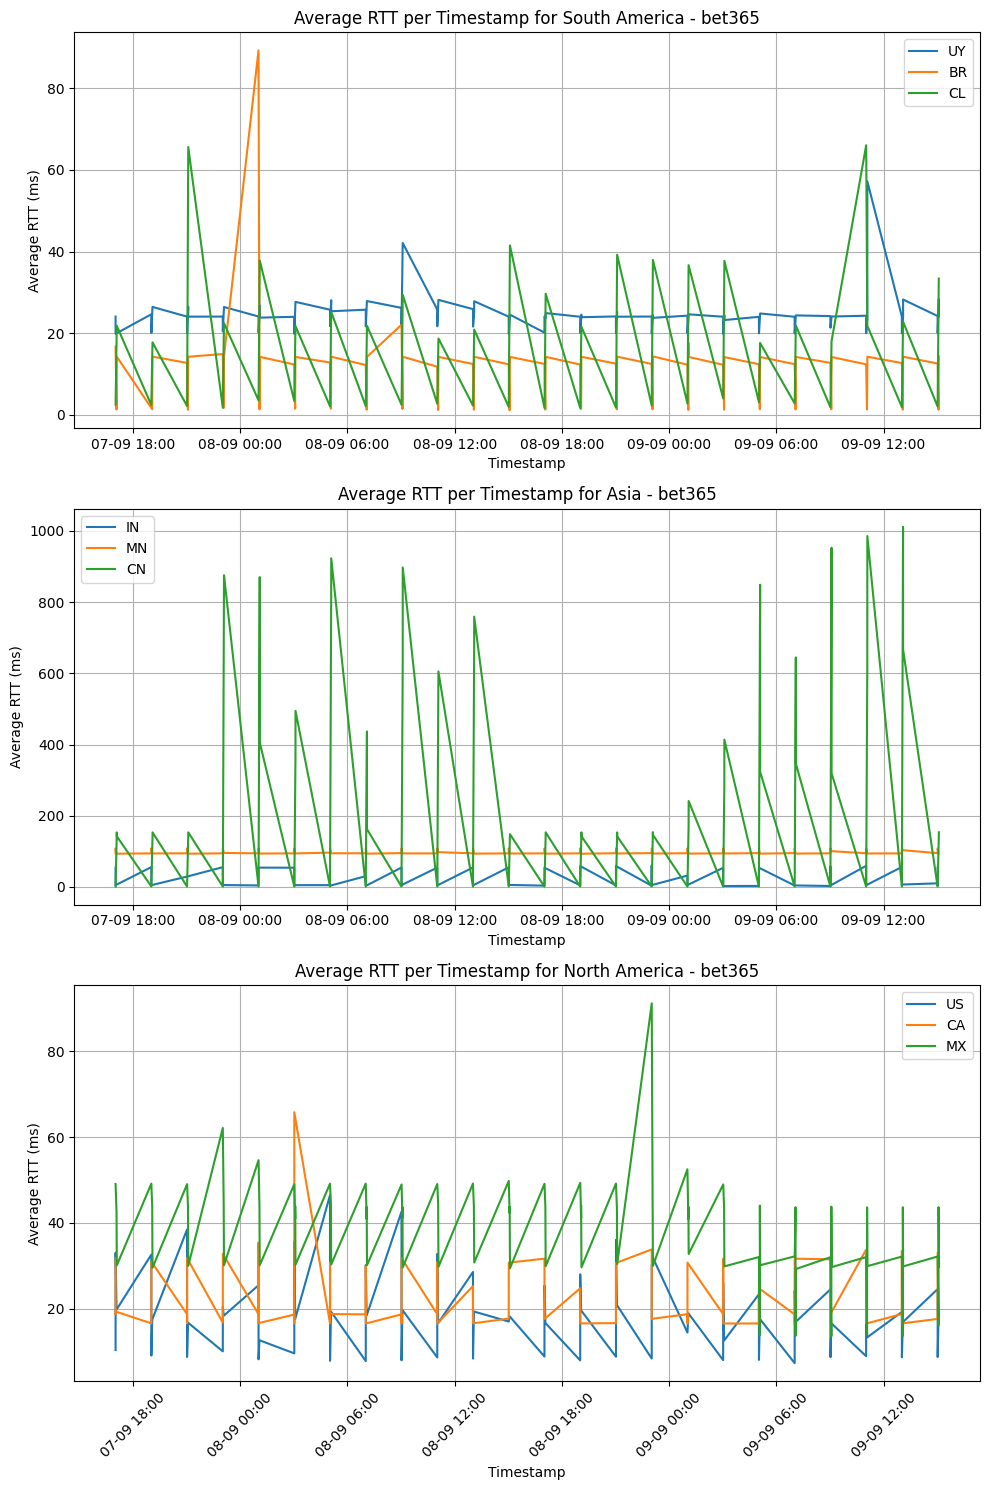

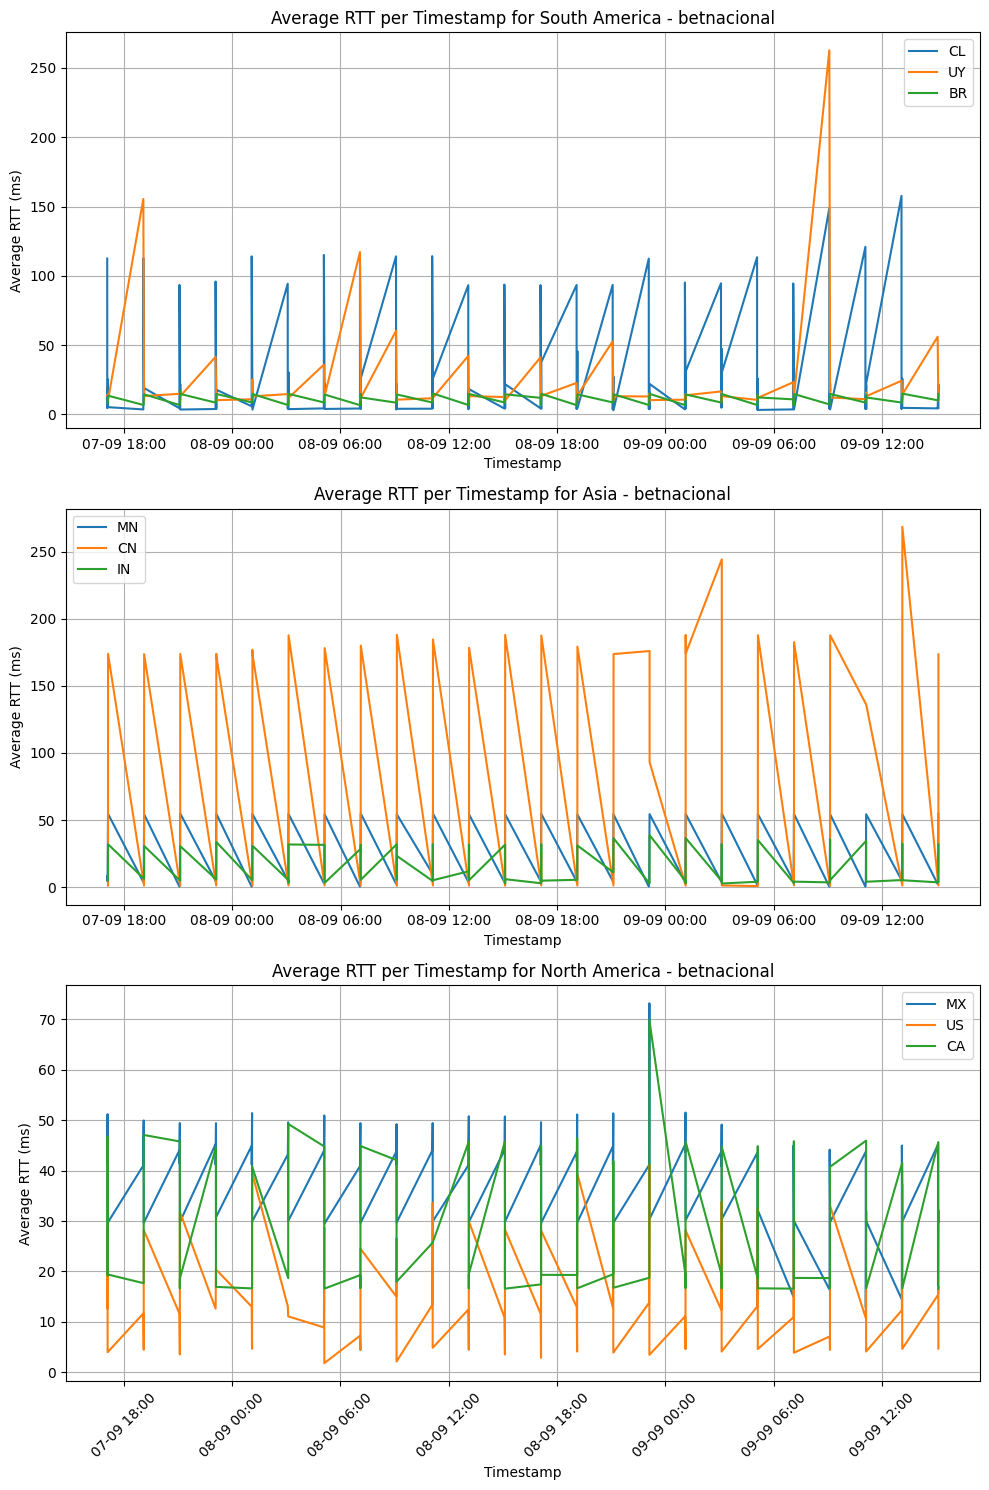

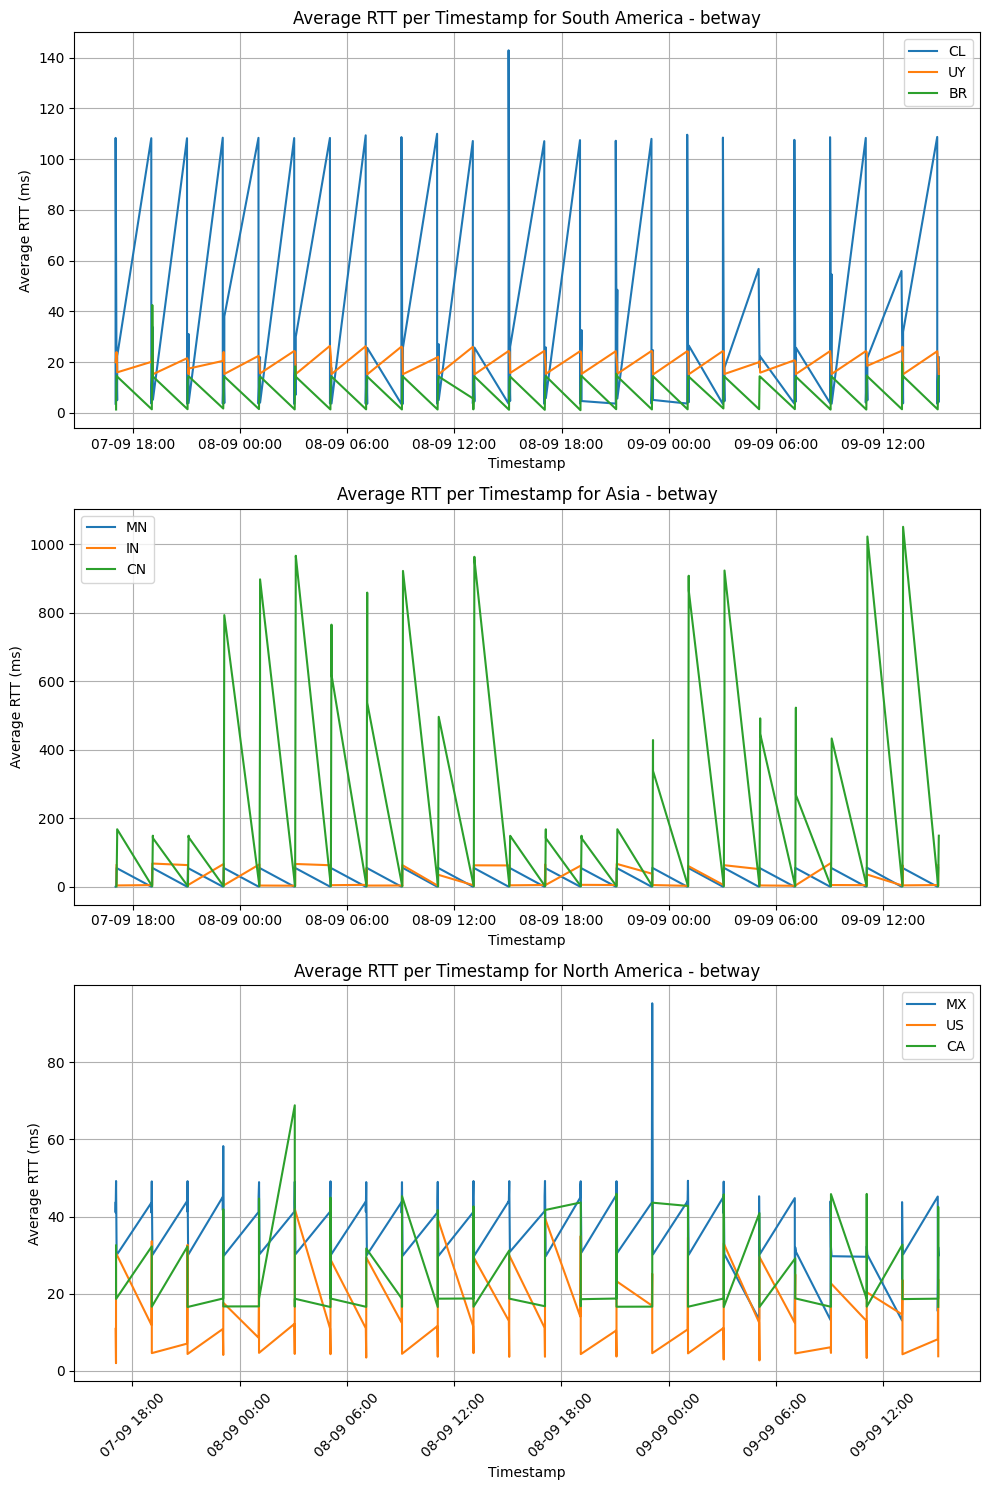

In [113]:
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

# Initialize a dictionary to store the average RTT per timestamp for each country and destination
average_rtt = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Iterate over the destination_country_probes dictionary
for destination, countries in destination_country_probes.items():
    for country, probes in countries.items():
        for probe in probes:
            if probe.result and probe.result[-1].get("result"):
                rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                timestamp = probe.timestamp
                if rtt > 0:  # Only consider non-zero RTTs
                    average_rtt[destination][country][timestamp].append(rtt)

# Calculate the average RTT for each timestamp for each country
for destination, countries in average_rtt.items():
    for country, timestamps in countries.items():
        for timestamp, rtts in timestamps.items():
            average_rtt[destination][country][timestamp] = sum(rtts) / len(rtts)

# Plot the data
for destination, countries in average_rtt.items():
    # Separate the countries by continent
    south_america = ["BR", "UY", "CL"]
    asia = ["CN", "MN", "IN"]
    north_america = ["US", "CA", "MX"]
    
    continents = {
        "South America": south_america,
        "Asia": asia,
        "North America": north_america
    }
    
    # Create subplots for each continent
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    fig.subplots_adjust(hspace=0.5)
    
    for i, (continent, continent_countries) in enumerate(continents.items()):
        ax = axes[i]
        
        # Plot data for each country in the current continent
        for country, timestamps in countries.items():
            if country not in continent_countries:
                continue
            # Sort the timestamps for plotting
            sorted_timestamps = sorted(timestamps.keys())
            sorted_times = [datetime.fromtimestamp(timestamp) for timestamp in sorted_timestamps]
            sorted_rtts = [timestamps[timestamp] for timestamp in sorted_timestamps]
            
            # Ensure both lists are of the same length and contain valid numeric values
            if len(sorted_times) == len(sorted_rtts) and all(isinstance(rtt, (int, float)) for rtt in sorted_rtts):
                ax.plot(sorted_times, sorted_rtts, linestyle='-', label=country)
        
        # Format the x-axis to display date and time correctly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Average RTT (ms)')
        ax.set_title(f'Average RTT per Timestamp for {continent} - {destination}')
        ax.legend()
        ax.grid(True)
    
    # Final adjustments for layout and display
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

